# Analysing 1D SWE model outputs across a variety of different parameters

Recall the SWE:

\begin{align*}
    \partial_t u + u \cdot \nabla u + g \nabla \eta - \nu \nabla^2 u &= 0, \\
    \partial_t \eta + \nabla \cdot ((\eta + \eta) u) &= 0.
\end{align*}

For our paper simulation study -- and thus, also in this notebook -- we are looking at analysing the results of running statFEM for the SWE, with different viscosity parameters $\nu$, topographies $H$, and observation intervals. We will mainly analyse outputs in terms of the relative RMSE:

\begin{equation*}
    \mathrm{RMSE} = \frac{\Vert y_m - H(u_m, h_m)\Vert}{\Vert y_m \Vert},
\end{equation*}

and also the (negative) log-likelihoods to get a better, more probabilistic, metric for comparison.

In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

def errors_from_output_file(output_file, prior=False):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    c = checkpoint["/"].attrs["c"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 1e-2 
    t_obs = checkpoint["/t_obs"][:]
    rmse = checkpoint["/rmse"][:]
    rmse_rel = checkpoint["/rmse_rel"][:]
    
    # common coordinates across all
    coords=dict(t=t_obs,
                nu=np.array([nu]),
                c=np.array([c]),
                nt_skip=np.array([nt_skip]))
    
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis, np.newaxis, np.newaxis],
                           coords=coords,
                           name="rmse")
    rmse_rel_ds = xr.DataArray(data=rmse_rel[:, np.newaxis, np.newaxis, np.newaxis],
                               coords=coords,
                               name="rmse_rel")
    if not prior:
        lml = checkpoint["/lml"][:]
        checkpoint.close()
        
        lml_ds = xr.DataArray(data=lml[:, np.newaxis, np.newaxis, np.newaxis],
                              coords=coords,
                              name="lml")
        return (nu, nt_skip), xr.merge([rmse_ds, rmse_rel_ds, lml_ds])
    else:
        checkpoint.close()
        return (nu, nt_skip), xr.merge([rmse_ds, rmse_rel_ds])

In [2]:
from glob import glob

output_files = glob(
    "../outputs/swe-bump/*-posterior-c-*-nt_skip-25-*.h5")

errors_ds = []
for output_file in output_files:
    _, e = errors_from_output_file(output_file)
    errors_ds.append(e)

errors_nonlinear = xr.merge(errors_ds)
errors_nonlinear

<xarray.Dataset>
Dimensions:   (t: 800, nu: 7, c: 8, nt_skip: 1)
Coordinates:
  * t         (t) float64 0.01 0.26 0.51 0.76 1.01 ... 199.0 199.3 199.5 199.8
  * nu        (nu) float64 0.0 1e-06 0.0001 0.01 1.0 100.0 1e+04
  * c         (c) float64 5.0 7.0 10.0 11.0 12.0 15.0 20.0 22.0
  * nt_skip   (nt_skip) int64 25
Data variables:
    rmse      (t, nu, c, nt_skip) float64 6.055e-05 6.055e-05 ... 0.000413
    rmse_rel  (t, nu, c, nt_skip) float64 0.1217 0.1217 0.1217 ... 2.49 2.488
    lml       (t, nu, c, nt_skip) float64 -1.163e+08 -1.163e+08 ... -5.411e+09

In [3]:
output_files_prior = glob(
    "../outputs/swe-bump/*-prior-c-*-nt_skip-50-*.h5")

errors_ds = []
for output_file in output_files_prior:
    _, e = errors_from_output_file(output_file, prior=True)
    errors_ds.append(e)

errors_prior = xr.merge(errors_ds)
errors_prior

<xarray.Dataset>
Dimensions:   (t: 400, nu: 7, c: 8, nt_skip: 1)
Coordinates:
  * t         (t) float64 0.01 0.51 1.01 1.51 2.01 ... 198.0 198.5 199.0 199.5
  * nu        (nu) float64 0.0 1e-06 0.0001 0.01 1.0 100.0 1e+04
  * c         (c) float64 5.0 7.0 10.0 11.0 12.0 15.0 20.0 22.0
  * nt_skip   (nt_skip) int64 50
Data variables:
    rmse      (t, nu, c, nt_skip) float64 6.055e-05 6.055e-05 ... 0.0004572
    rmse_rel  (t, nu, c, nt_skip) float64 0.1217 0.1217 0.1217 ... 2.836 2.836

Now we filter the output information to that which we are actually interested.

In [4]:
errors_prior = errors_prior.isel(c=[0, 1, 2, 5, 6])
errors_nonlinear = errors_nonlinear.isel(c=[0, 1, 2, 5, 6])

First, we plot the results across the different values of the $c$ parameter (centre of the bump), when $\nu$ is set to sensible values. To get a feel for how conditioning on data helps, we first plot the prior:

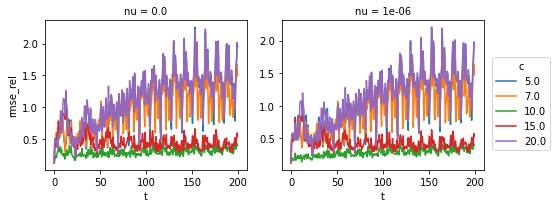

In [5]:
errors_prior.rmse_rel.interpolate_na(dim="t").isel(nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False)
plt.show()

Next, we plot the posterior. On the left, below, are the results for the linear model, and on the right are the results of the nonlinear model. Results are sensible with quite significant stratification across the $c$ values. We see that there is a reasonable drop in the relative errors in comparison to the prior:

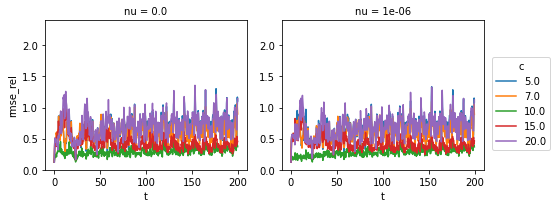

In [6]:
errors_nonlinear.rmse_rel.interpolate_na(dim="t").isel(nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False, ylim=[0., 2.4])
plt.show()

Next, we plot these same results, but we instead use the log-marginal likelihood as the metric. The stratification here becomes more apparent across the board:

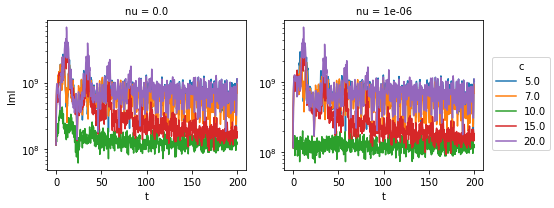

In [7]:
np.abs(errors_nonlinear).lml.interpolate_na(dim="t").isel(nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False, yscale="log")
plt.show()

And now for total comparison we show all of these results, for all the $\nu$ values:

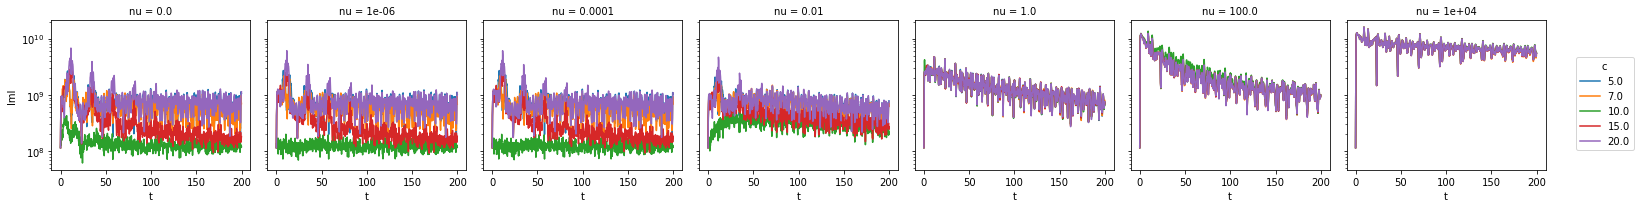

In [8]:
np.abs(errors_nonlinear.lml).interpolate_na(dim="t").plot(
    hue="c", col="nu", sharey=True, yscale="log")
plt.show()

Next, we plot the results for the true value of $c$, for the various values of $\nu$. We see that there is a drastic change in the dynamics as we increase $\nu \geq 1$; once setting $\nu = 1$ this induces a degree of mismatch which results in the model not improving *a posteriori*:

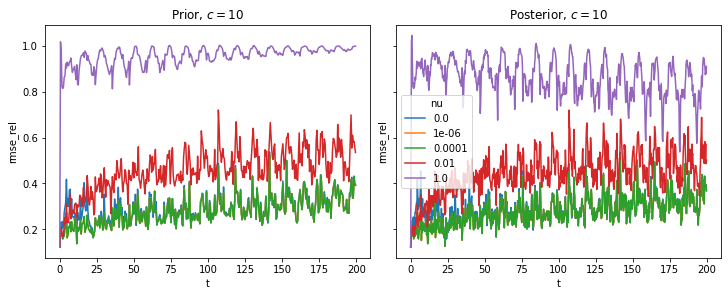

In [9]:
nu = [0, 1, 2, 3, 4]
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4), sharey=True)
errors_prior.rmse_rel.isel(nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", ax=ax[0], add_legend=False)
ax[0].set_title("Prior, $c = 10$")
errors_nonlinear.rmse_rel.isel(nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", ax=ax[1], add_legend=True)
ax[1].set_title("Posterior, $c = 10$")
plt.show()

Next, we plot the log-marginal likelihoods for the true value $c = 10$, again stratified across the different $\nu$ values. In this case we see that there is a clear stratification as a result of the $\nu$.

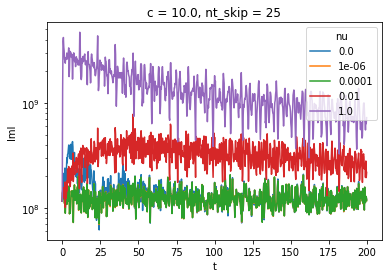

In [10]:
nu = nu
np.abs(errors_nonlinear.lml).isel(nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", add_legend=True, yscale="log")
plt.show()

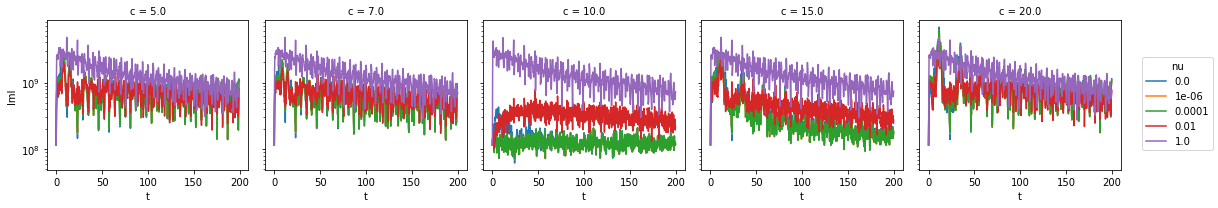

In [11]:
np.abs(errors_nonlinear.lml).isel(nu=nu).interpolate_na(dim="t").plot(
    hue="nu", col="c", sharey=True, yscale="log")
plt.show()

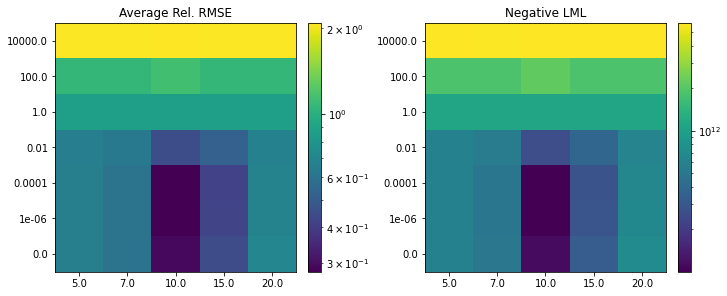

In [12]:
import matplotlib.colors as colors

# mean the RMSEs, sum the LMLs
total_rmse = errors_nonlinear.mean(dim="t").rmse_rel
total_lml = np.abs(errors_nonlinear.lml).sum(dim="t")

rmse_array = errors_nonlinear.mean(dim="t").rmse_rel.to_numpy()[:, :, 0]
lml_array = np.abs(errors_nonlinear.sum(dim="t")).lml.to_numpy()[:, :, 0]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
im = ax[0].pcolormesh(range(len(total_rmse.coords["c"].to_numpy())), 
                      range(len(total_rmse.coords["nu"].to_numpy())),
                      rmse_array,
                      norm=colors.LogNorm(vmin=rmse_array.min(), 
                                          vmax=rmse_array.max()))
ax[0].set_xticks(range(len(total_rmse.coords["c"].to_numpy())), 
                 total_rmse.coords["c"].to_numpy())
ax[0].set_yticks(range(len(total_rmse.coords["nu"].to_numpy())), 
                 total_rmse.coords["nu"].to_numpy())
ax[0].set_title("Average Rel. RMSE")
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(range(len(total_lml.coords["c"].to_numpy())), 
                      range(len(total_lml.coords["nu"].to_numpy())),
                      lml_array,
                      norm=colors.LogNorm(vmin=lml_array.min(), 
                                          vmax=lml_array.max()))
ax[1].set_xticks(range(len(total_lml.coords["c"].to_numpy())), 
                 total_lml.coords["c"].to_numpy())
ax[1].set_yticks(range(len(total_lml.coords["nu"].to_numpy())), 
                 total_lml.coords["nu"].to_numpy())
ax[1].set_title("Negative LML")
plt.colorbar(im, ax=ax[1])
plt.show()

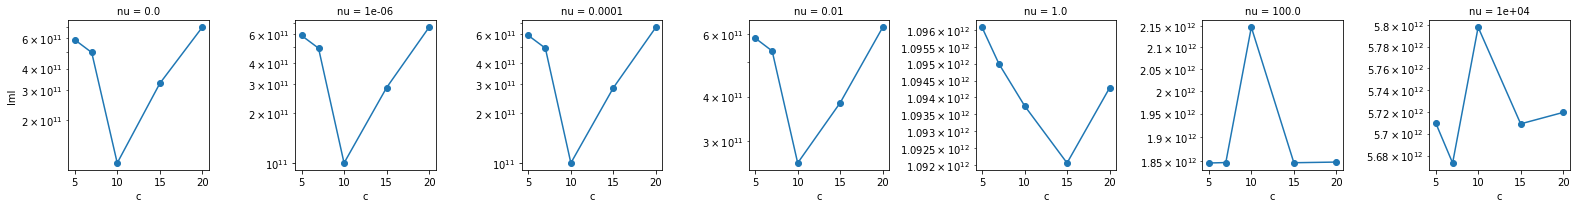

In [13]:
total_lml.plot(marker="o", col="nu", yscale="log", sharey=False)
plt.show()

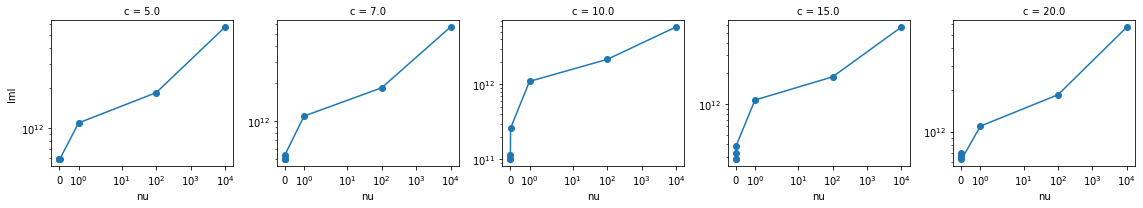

In [14]:
total_lml.plot(marker="o", col="c", xscale="symlog", yscale="log",sharey=False)
plt.show()